In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
import math
from sklearn.metrics import accuracy_score
from config import ExperimentConfig
from experiments.experiment import Experiment
#from config.common_path import get_ba
%matplotlib inline


/usr/local/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
pd.set_option('display.max_columns', 400)

In [3]:
ROOT_PATH = "/Users/sunilkumar/concept_learning_old/image_classification_old/"
DOC_PATH ="/Users/sunilkumar/concept_learning/writeup/"
N_3 = 16
N_2 = 128
Z_DIM = 5
exp_config = ExperimentConfig(ROOT_PATH, 4, Z_DIM, [64, N_2, N_3])
run_id = 1
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name
SPLIT_NAME = exp_config.split_name
run_ids = [1]
if not exp_config.check_and_create_directories(run_ids, create=False):
    raise Exception("Directories does not exist")
DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS = exp_config.DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS
# filename  = get_encoded_csv_file(N_2, N_3, Z_DIM, "train")
# mean_col_names, sigma_col_names, z_col_names = get_latent_vector_column(Z_DIM)

In [4]:
def get_base_path(root_path, z_dim, n_3, n_2, version = ""):
    return os.path.join(root_path, "Exp_{:02d}_{:03}_{:03d}_{}/".format(z_dim, n_3, n_2, version))


In [5]:
MODEL_NAME ="VAE"

annotator = "SUNIL"
num_label_files = 2
NUMBER_OF_ROWS = 16
NUM_DIGITS_PER_ROW = 4
MAX_BACKUPS = 10
ANNOTATED_CSV = "annotation.csv"
last_epoch = 20
eval_interval = 300

num_label_files = 2
num_rows_per_image = 16
num_digits_per_row = 4



In [6]:
def read_label(label_file):
    labels = {}
    for file_number in range(num_label_files):
        label_df = pd.read_csv(label_file.format(file_number))
        #label_df = pd.read_csv(label_file)
        labels[file_number] = label_df["label"].values
    return labels

def get_label_reconstructed(_df):
    labels =  np.ones(num_rows_per_image * num_digits_per_row) * -2
    _df = _df.fillna("xxxx")
    for row in _df.iterrows():
        text_ = [-1] * num_digits_per_row

        row_text_ = row[1]["text"]
        if isinstance(row_text_,float):
            row_text_ = str(row_text_)
        row_text_ = row_text_.strip()
        if len(row_text_) != 0:
            if len(row_text_) < 4:
                for i in range(4-len(row_text_)):
                    text_[i] = 0
            offset = 4 - len(row_text_)
            for i,c in enumerate(row_text_):
                if c.isdigit():
                    text_[i+offset] = int(c)
                elif c == 'x':
                    text_[i+offset] = -1
                else:
                    raise Exception("Invalid character in annotated data - ",row[1]["num_rows_annotated"])

        for i in range(num_digits_per_row)  :
            offset = (row[1]["num_rows_annotated"] - 1) * num_digits_per_row
            labels[i + offset] = text_[i]

    return labels


In [7]:
def _compute_accruacy(df, step, epoch, num_label_files, labels):
    df1 = df[(df["epoch"] == epoch) & (df["step"] == step)]
    labels_batch = []
    reconstructed_batch = []
    for image_no in range(num_label_files):
        _df = df1[df1["_idx"] == image_no]
        if _df.shape[0] > 0 :
            try:
                reconstructed = get_label_reconstructed(_df[["num_rows_annotated", "text"]])
            except Exception as e:
                print("Invalid character in annotation,epoch {:01d} , step {:01d}".format(epoch,step))
                print(str(e))
                continue
                #exit()
            _reconstructed_indices = reconstructed != -2
            reconstructed_batch.extend(reconstructed[_reconstructed_indices])
            labels_batch.extend(labels[image_no][_reconstructed_indices])
    accuracy = accuracy_score(labels_batch,reconstructed_batch)
    return accuracy


In [8]:
def get_annotations(annotated_path):
    df = None
    for annotation_file in os.listdir(annotated_path):
        if annotation_file.rsplit(".",1)[1] == "csv":
            annotation_csv = os.path.join(ANNOTATED_PATH, annotation_file)
            _df = pd.read_csv(annotation_csv)
            if df is None:
                df = _df
            else:
                df = pd.concat([df,_df])

    unique = df.groupby(["epoch","step"]).size().reset_index().rename(columns={0:'count'})
    return df,unique

def compute_accuracy(labels, gt_dir, max_epoch):
    df,unique = get_annotations(gt_dir)
    unique = unique[unique["count"] > 10]
    
    epochs = []
    steps = []
    accuracies = []
    total_batches_finished = []
    for unique_combination in unique.iterrows():
        epoch = unique_combination[1]["epoch"]
        step = unique_combination[1]["step"]
        #print(epoch,step)
        accuracy = _compute_accruacy(df,step,epoch, num_label_files,labels)
        accuracies.append(accuracy)
        total_batches_finished.append(epoch * 935 + step * eval_interval )
    accuracy_df = pd.DataFrame({"Total_Batches_Finished":total_batches_finished,"Epochs":np.asarray(total_batches_finished)/935,"Accuracy":accuracies})
    accuracy_df = accuracy_df[accuracy_df["Epochs"] < max_epoch]
    return accuracy_df


In [9]:
run_id = 1
accuracy_dict =dict()
max_epoch = 5
#for z_dim in [20]:
for z_dim in [5,10]:
#for z_dim in [1, 2, 5, 10, 20]:
    BASE_PATH = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=run_id)
    DATASET_ROOT_PATH = os.path.join(BASE_PATH, DATASET_NAME+"/")
    DATASET_PATH = os.path.join(DATASET_ROOT_PATH, SPLIT_NAME+"/")
    MODEL_NAME_WITH_CONFIG = "{}_{}_{:2d}_{:02d}".format(MODEL_NAME, DATASET_NAME, BATCH_SIZE, z_dim)
    MODEL_PATH = os.path.join(DATASET_PATH, MODEL_NAME_WITH_CONFIG)
    SPLIT_PATH = os.path.join(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS, SPLIT_NAME + "/")
    TRAINED_MODELS_PATH = os.path.join(MODEL_PATH, "trained_models/")
    PREDICTION_RESULTS_PATH = os.path.join(MODEL_PATH, "prediction_results/")
    ANNOTATED_PATH = DATASET_PATH + "manual_annotation"
    
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file)

    accuracy_df = compute_accuracy(labels, ANNOTATED_PATH, max_epoch)
    accuracy_dict[z_dim] = [max(accuracy_df["Accuracy"].values),accuracy_df]


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


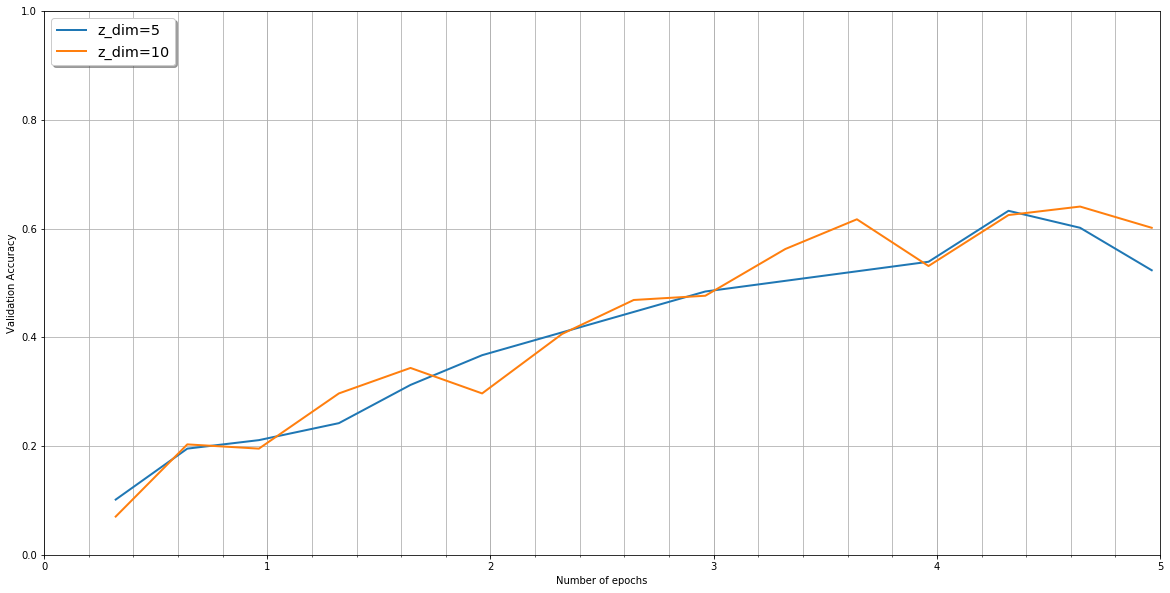

In [10]:
from matplotlib.ticker import MultipleLocator
num_training_samples = 59872
steps_per_epoch = num_training_samples / BATCH_SIZE
max_steps =  max_epoch * steps_per_epoch
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy.jpg"
for z_dim, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])
    plt.plot(x,y,label="z_dim={}".format(z_dim),lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Validation Accuracy")
    
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlim(0,max_epoch)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.savefig(os.path.join(ROOT_PATH,"combined_analysis",plot_filename),bbox="tight") 
plt.savefig(os.path.join(DOC_PATH,plot_filename), bbox="tight")

In [13]:
for z_dim, result in accuracy_dict.items():
    print(z_dim, max(result[1]["Accuracy"].values))

5 0.6328125
10 0.640625


In [14]:
accuracy_dict =dict()
max_epoch = 5
z_dim = 5
run_ids = [1]
for run_id in run_ids:
    BASE_PATH = get_base_path(ROOT_PATH,z_dim,N_3, N_2,version=run_id)
    DATASET_ROOT_PATH = os.path.join(BASE_PATH, DATASET_NAME+"/")
    DATASET_PATH = os.path.join(DATASET_ROOT_PATH, SPLIT_NAME+"/")
    MODEL_NAME_WITH_CONFIG = "{}_{}_{:2d}_{:02d}".format(MODEL_NAME, DATASET_NAME, BATCH_SIZE, z_dim)
    MODEL_PATH = os.path.join(DATASET_PATH, MODEL_NAME_WITH_CONFIG)
    SPLIT_PATH = os.path.join(DATASET_PATH_COMMON_TO_ALL_EXPERIMENTS, SPLIT_NAME + "/")
    TRAINED_MODELS_PATH = os.path.join(MODEL_PATH, "trained_models/")
    PREDICTION_RESULTS_PATH = os.path.join(MODEL_PATH, "prediction_results/")
    ANNOTATED_PATH = DATASET_PATH + "manual_annotation"
    label_file = PREDICTION_RESULTS_PATH + "/label_test_{:02d}.csv"
    labels = read_label(label_file)

    accuracy_df = compute_accuracy(labels, ANNOTATED_PATH, max_epoch)
    accuracy_dict[run_id] = [max(accuracy_df["Accuracy"].values),accuracy_df]
    

In [15]:
num_evaluations = accuracy_dict[run_ids[0]][1].shape[0]

1
reconstruction_accuracy_different_runs.jpg


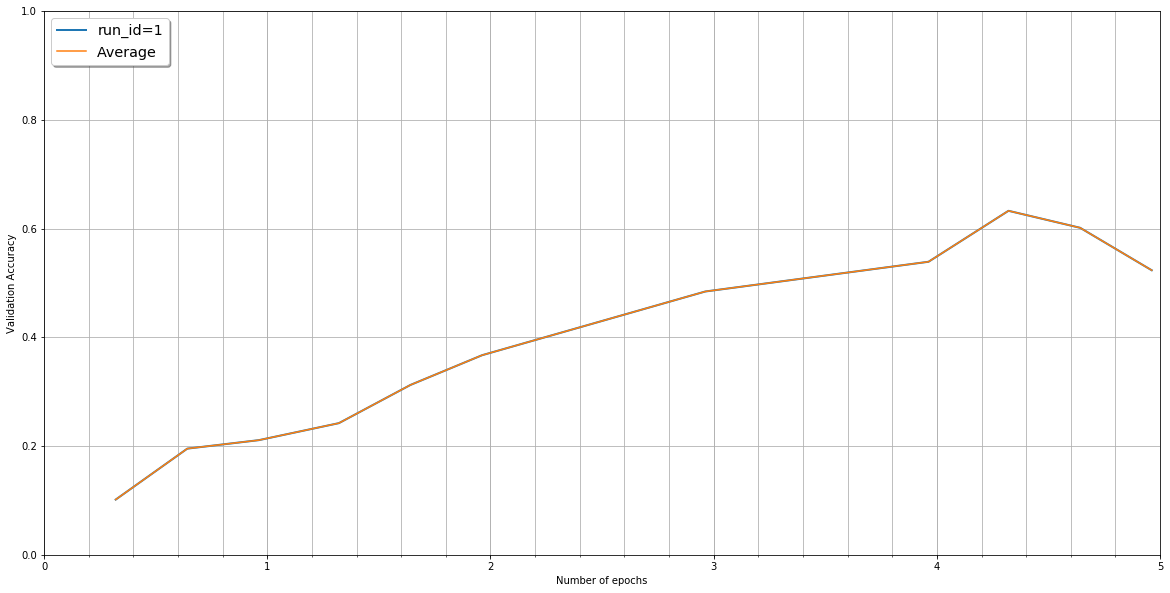

In [16]:
plt.figure(figsize=(20,10))
plot_filename = "reconstruction_accuracy_different_runs.jpg"
total = np.zeros(num_evaluations)
for run_id, result in accuracy_dict.items():
    max_accuracy = result[0]
    accuracy_df = result[1]
    x = accuracy_df["Epochs"].values
    x = x.reshape(x.shape[0])
    y = accuracy_df["Accuracy"].values
    y = y.reshape(y.shape[0])

    plt.plot(x,y,label="run_id={}".format(run_id),lw=2)
    plt.xlabel("Number of epochs")
    plt.ylabel("Validation Accuracy")
    print(run_id)
    total = total + y
average = total / len(run_ids)
plt.plot(x, average,label = "Average")

plt.legend(loc='upper left', shadow=True, fontsize='x-large')
print(plot_filename)
plt.xlim(0,max_epoch)
plt.ylim(0,1)
plt.grid(which="both")
plt.axes().xaxis.set_minor_locator(MultipleLocator(0.2))
plt.savefig(os.path.join(ROOT_PATH,"combined_analysis",plot_filename),bbox="tight") 
plt.savefig(os.path.join(DOC_PATH,plot_filename), bbox="tight")

In [16]:
print(max(average))

0.6328125


In [ ]:
for run_id, result in accuracy_dict.items():
    accuracy = result[1]["Accuracy"].values
    max_index = np.argmax(accuracy)
    print(run_id, result[1]["Total_Batches_Finished"].values[max_index], 
          result[1]["Epochs"].values[max_index],
          max(accuracy), max_index)

In [ ]:
result[0]

In [ ]:
result[1]